# Redes totalmente convolucionais

Este notebook aborda os seguintes aspectos relacionados às redes totalmente convolucionais:
- como transformar uma camada densa em convolucional, aproveitando seus pesos;
- como criar, a partir de uma rede pré-treinada para classificar imagens, uma rede totalmente convolucional;
- demostrar que uma rede totalmente convolucional, quando aplicada em imagens maiores que aquelas usadas em seu treinamento, implementa uma varredura implícita com ganhos de eficiência.


In [1]:
# import os
# os.environ['KERAS_BACKEND'] = 'theano'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
# # os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import sys
import time
import numpy as np
import argparse
import cv2

import theano
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout

from keras.optimizers import SGD, RMSprop
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
from sklearn import datasets

print 'Keras ', keras.__version__
print 'Theano', theano.__version__
print 'OpenCV', cv2.__version__
print 'Numpy ', np.__version__

Keras  1.2.0
Theano 0.8.2
OpenCV 3.1.0
Numpy  1.11.3


Using Theano backend.
/opt/conda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### MNIST dataset

In [3]:
sys.path.append('../src')
from keras.datasets import mnist
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

(X_train, y_train_), (X_test, y_test_) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 28, 28) / 255.0
X_test = X_test.reshape(-1, 1, 28, 28) / 255.0

y_train = np_utils.to_categorical(y_train_, 10)
y_test = np_utils.to_categorical(y_test_, 10)

print X_train.shape, X_test.shape
print y_train.shape, y_test.shape

(60000, 1, 28, 28) (10000, 1, 28, 28)
(60000, 10) (10000, 10)


## Carregando nosso modelo pre-treinado

In [4]:
print("[INFO] loading model...")
model_name = './keras_lenet_1'
model_A, histo_A = load_model_and_history(model_name)

print("[INFO] evaluating...")
loss, accuracy = model_A.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

model_A.summary()

[INFO] loading model...
[INFO] evaluating...
10000/10000 [==============================] - 4s     

## Modelo totalmente convolucional equivalente

O modelo seguinte é todo ele convolucional.

A primeira camada densa do modelo tem como entrada um tensor de dimensão 2450, resultante do redimensionamento (via *Flatten*) da saída do *Dropout*, 50x7x7. Esta camada gera uma saída com dimensão 500. Seus pesos têm portanto dimensão 2450x500.

Uma camada convolucional que substitua estas camadas *Flatten* e *Dense* terá como entrada um tensor 50x7x7. Para gerar uma saída 500x1x1, a convolução deve criar 500 mapas com um kernel 7x7 e com borda do tipo 'valid'.

Para substituir a última camada densa, usamos uma convolução com 10 mapas e kernel 1x1.


- FIGURA


In [5]:
model_name = './keras_lenet_fullconv'

class LeNet:
    @staticmethod
    def build():
        model = Sequential()
        
        model.add(Convolution2D(20, 5, 5, border_mode="same", 
                                batch_input_shape=(128, 1, None, None)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Convolution2D(50, 5, 5, border_mode="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Convolution2D(500, 7, 7, border_mode="valid"))        
        model.add(Activation("relu"))

        model.add(Convolution2D(10, 1, 1, border_mode="valid"))        

        return model

model_B = LeNet.build()
model_B.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (128, 20, None, None) 520         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (128, 20, None, None) 0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (128, 20, None, None) 0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (128, 50, None, None) 25050       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

## Ajustando os pesos do modelo todo convolucional

- FIGURA


In [6]:
W_all_A = model_A.get_weights()

W_all_B = [
    W_all_A[0],
    W_all_A[1],
    W_all_A[2],
    W_all_A[3],
    W_all_A[4].T.reshape(500, 50, 7, 7)[:, :, ::-1, ::-1],
    W_all_A[5],
    W_all_A[6].T.reshape(10, 500, 1, 1)[:, :, ::-1, ::-1],
    W_all_A[7],
]
model_B.set_weights(W_all_B)

model_B.compile(optimizer='sgd', loss="categorical_crossentropy")


## Verificando a performance

In [7]:
def softmax(Z, axis=-1):
    EZ = np.exp(Z)
    S = EZ / EZ.sum(axis=axis,keepdims=True)
    return S

pp = model_B.predict(X_test)
pp = softmax(pp, 1)

In [8]:
smo = np.argmax(pp, axis=1).reshape(-1)
print 100.0 * np.where(smo == y_test_, 1, 0).sum() / y_test_.shape[0]

99.29


## Janela deslizante

Agora que temos uma rede toda convolucional, vejamos o que acontece se a imagem de entrada é maior que as imagens utilizadas para treinamento (28x28).

A figura abaixo, ilustra o processo mostrando as dimensões dos *features* através de uma linha da imagem de entrada com dimensões 36x36. Acompanhemos cada passo:

- imagem de entrada (representada na figura em uma dimensão apenas): 1x36x36;
- convolução 20 filtros 5x5, borda *'same'*: 20x36x36
- maxpool 2x2, stride 2x2: 20x18x18
- convolução 50 filtros 5x5, borda *'same'*: 50x18x18
- maxpool 2x2, stride 2x2: 50x9x9
- convolução 500 filtros 7x7, borda *'valid'*: 500x3x3
- convolução 10 filtros 1x1: 10x3x3

![capa](../figures/fully_conv_3.png)


In [9]:
M = 200
N = 5
char_index = np.random.choice(X_test.shape[0], N, replace=False)
char_img = [img.reshape(28,28) for img in (255*X_test).astype(np.uint8)[char_index]]
char_lab = [y for y in y_test_[char_index]]

image = np.zeros((M, M), np.uint8)
# coords = []
# for k, (i, j) in enumerate(np.random.choice((M-28), (N, 2), replace=False)):
#     image[i:i+28, j:j+28] = np.maximum(image[i:i+28, j:j+28], char_img[k])
#     coords.append((char_lab[k], i, j))

coords = [(0, 0), (50, 150), (100, 100), (171, 171)]
xlabel = []
for k, (i, j) in enumerate(coords):
    image[i:i+28, j:j+28] = char_img[k]
    xlabel.append(char_lab[k])
    

(10, 44, 44) (44, 44)


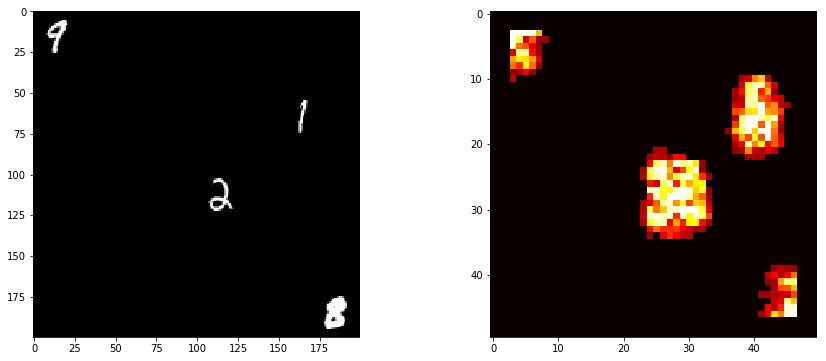

In [13]:
fig = plot.figure(figsize=(15,6)) 

fig.add_subplot(1,2,1)
plot.imshow(image, cmap=plot.cm.gray)

in_image = image.astype(np.float32).reshape(1, 1, M, M) / 255.0

pp = model_B.predict(in_image)[0]
pp = softmax(pp, 0)

pmax = pp.max(0)
pmax = np.where(pmax < 0.2, 0, pmax)
print pp.shape, pmax.shape

hm = np.zeros((50,50), pmax.dtype)
hm[3:-3, 3:-3] = pmax

fig.add_subplot(1,2,2)
plot.imshow(255 * hm, cmap=plot.cm.hot)


0.0 1.0
(10, 172, 172) (172, 172) 0.999967 9 0.999434 8


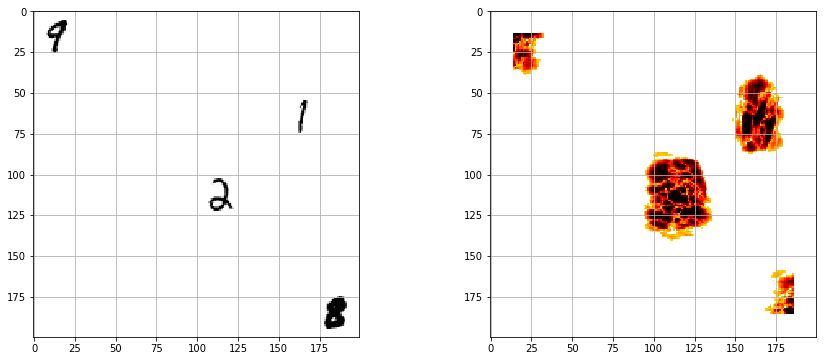

In [16]:
fig = plot.figure(figsize=(15,6)) 

fig.add_subplot(1,2,1)
plot.imshow(255 - image, cmap=plot.cm.gray)
plot.grid(True)

output = np.zeros((10, 172, 172), np.float32)
for i in range(4):
    for j in range(4):
        output[:, i::4, j::4] = model_B.predict(in_image[:, :, i:i+196, j:j+196])[0]

output = softmax(output, 0)
pmax = output.max(0)
imax = output.argmax(0)
pmax = np.where(pmax < 0.3, 0, pmax)
print pmax.min(), pmax.max()
print output.shape, pmax.shape, pmax[0,0], imax[0,0], pmax[-1,-1], imax[-1,-1]

phm = np.zeros((200,200), pmax.dtype)
phm[14:-14, 14:-14] = pmax

ihm = np.zeros((200,200), imax.dtype)
ihm[14:-14, 14:-14] = imax

fig.add_subplot(1,2,2)
plot.imshow(255 * (1.0 - phm), cmap=plot.cm.hot)
plot.imsave('heatmap.png', 255 * pmax)
plot.grid(True)

In [18]:
for k, (i, j) in zip(xlabel, coords):
    print 'p = {:.5f}, char: \'{}\' [correct: \'{}\']'.format(phm[i+14, j+14], ihm[i+14, j+14], k)


p = 0.99997, char: '9' [correct: '9']
p = 0.99993, char: '1' [correct: '1']
p = 1.00000, char: '2' [correct: '2']
p = 0.99943, char: '8' [correct: '8']
